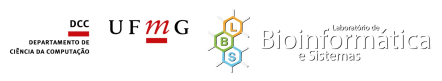

Federal University of Minas Gerais

Department of Computer Science

[Bioinformatics and Systems Laboratory](http://bioinfo.dcc.ufmg.br/)

Authors: Lucas Moraes and Prof. Dr. Raquel Cardoso de Melo-Minardi

In [ ]:
'''
The provided source code is designed to evaluate model performance through a sequence of operations, including importing
weights from trained models, making predictions on unseen test data, and ranking these predictions using a predefined
threshold. It calculates several standard performance metrics such as accuracy, precision, recall, and specificity and
visualizes the results using a confusion matrix. Furthermore, the code incorporates functions to plot the Receiver Operating
Characteristic (ROC) curve, helping to evaluate the discriminative capacity of the model in different threshold configurations.
This evaluation is crucial to evaluate the model's effectiveness within the specific problem context and to refine model
parameters to improve performance. The reference to the number of instances in various sections of the notebook pertains to
the test set, although these values are adaptable for use during validation and parameter tuning. Essentially, the number of
instances mentioned here tends to be lower than in other contexts. The code has been used in the academic and research context
of the Department of Computer Science at the Federal University of Minas Gerais, specifically in the Bioinformatics and
Systems Laboratory.
'''

##### 1. **Evaluation**

In [1]:
# Standard Python libraries
import os
import time

# Data analysis and numerical operations
import numpy as np
import pandas as pd

# Data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Machine Learning and Neural Network libraries
import tensorflow as tf

from tensorflow.keras.models import Sequential, Model, load_model, clone_model
from tensorflow.keras.layers import (Dense, Activation, Concatenate, BatchNormalization,
                                     Dropout, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Flatten)
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array

# Sklearn metrics for model evaluation
from sklearn.metrics import auc, confusion_matrix, classification_report

> 1.1 Import the trained model

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

In [3]:
BASE_DIR = "/content/drive/My Drive/"

In [ ]:
# Load a pre-trained model from '/content/drive/My Drive/Models/'
model = load_model(BASE_DIR+'Models/model_wuhan_beta-delta_vgg_13_224_224_1e-03_05_100_64_0.9478.hdf5')

# Clone the configuration of the loaded model
model = clone_model(model)

'''
Set the weights of the cloned model to be identical to the original loaded model. This step ensures that
the cloned model retains the learned weights and can be used for inference.
'''
model.set_weights(model.get_weights())

> 1.2 Prediction

In [ ]:
# Create an ImageDataGenerator for test data
test_datagen = ImageDataGenerator(
    rescale=1./255
)

# Define the path to the test data
test_data_path = os.path.join(BASE_DIR, 'Dataset', 'Variants', 'Test')

# Generate test data from the directory
test_data = test_datagen.flow_from_directory(
    directory=test_data_path,  # Specify the directory path
    target_size=(224, 224),    # Specify the target size of the images
    batch_size=1,              # Set batch size to 1 for test data
    class_mode=None,           # No class labels are needed for test data
    shuffle=False,             # Do not shuffle the data
    seed=42                    # Set a seed for reproducibility
)

In [ ]:
# Reset the test data generator state before making predictions
test_data.reset()

# Make predictions on the test data
probabilities = model.predict(test_data, verbose=1)

> 1.3 Classification

In [23]:
# Define true labels for classification: 0 for '--' and 1 for '++'
neutral = np.full(35007,0)
positive = np.full(35007,1)

# Combine neutral and positive labels into a single array
true = np.concatenate((neutral, positive))

# Set a threshold for binary classification.
threshold = 0.5
predicted_class = [] # List to store predicted class labels
y_pred = []          # List to store predicted binary labels
y_probs = []         # List to store predicted probabilities

# Classify probabilities into '--' or '++' based on the threshold
for p in probabilities:
  if p[0]<threshold:
    predicted_class.append('--')
    y_pred.append(0)
  else:
    predicted_class.append('++')
    y_pred.append(1)
  y_probs.append(p[0])

y_pred = np.array(y_pred)
y_probs = np.array(y_probs)

print(classification_report(true, y_pred, labels=[0,1]))

> 1.4 Receiver Operating Curve

> 1.4.1 Confusion matrix

In [ ]:
# Define test labels and compute confusion matrix
zeros = np.zeros(35007)
ones = np.ones(35007)
y_test = np.concatenate([zeros, ones])
cm = confusion_matrix(y_test, y_pred)

cm

> 1.4.2 Function definition to obtain the ROC curve

In [ ]:
# Define function to calculate True Positive Rate (TPR) and False Positive Rate (FPR)
def calculate_tpr_fpr(y_real, y_pred):
    """
    Calculate True Positive Rate (TPR) and False Positive Rate (FPR) based on confusion matrix.
    """
    cm = confusion_matrix(y_real, y_pred)
    TN, FP, FN, TP = cm.ravel()

    tpr = TP / (TP + FN) if (TP + FN) != 0 else 0
    fpr = FP / (TN + FP) if (TN + FP) != 0 else 0

    return tpr, fpr

# Define function to obtain n coordinates for plotting the ROC curve
def get_n_roc_coordinates(y_real, y_proba, num_points=500):
    """
    Obtain coordinates for the ROC curve.
    """
    tpr_list, fpr_list = [0], [0]

    thresholds = np.linspace(0, 1, num_points, endpoint=False)[1:]  # Excluding 0 to start with the first threshold > 0
    for threshold in thresholds:
        y_pred = y_proba >= threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)

    tpr_list.append(1)
    fpr_list.append(1)  # Ensure the curve reaches (1,1)

    return tpr_list, fpr_list

# Plot the ROC curve using the defined functions
def plot_roc_curve(tpr, fpr, auc_area, scatter=True):
    """
    Plot the ROC curve and display AUC.
    """
    plt.figure(figsize=(5, 5))

    if scatter:
        sns.scatterplot(x=fpr, y=tpr)
    sns.lineplot(x=fpr, y=tpr, label=f'ROC curve (AUC = {auc_area:.2f})')

    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

> 1.4.3 Plotting the ROC curve

In [ ]:
tpr, fpr = get_n_roc_coordinates(y_test, y_probs)
auc_area = auc(np.sort(fpr), np.sort(tpr))  # Calculate AUC
plot_roc_curve(tpr, fpr, auc_area)

> 1.5 Calculation of performance metrics

In [ ]:
# Initialize counts for true positives, true negatives, false positives, and false negatives
true_positives = 0
true_negatives = 0
false_positives = 0
false_negatives = 0

# Convert the list of predicted class labels into a numpy array
predicted = np.array(predicted_class)

# Calculate the number of true negatives: instances correctly predicted as '--'
true_negatives = (predicted[0:35006]=="--").sum()

# Calculate the number of false positives: '--' instances incorrectly predicted as '++'
false_positives = (predicted[0:35006]=="++").sum()

# Calculate the number of true positives: instances correctly predicted as '++'
true_positives = (predicted[35007:70013]=="++").sum()

# Calculate the number of false negatives: '++' instances incorrectly predicted as '--'
false_negatives = (predicted[35007:70013]=="--").sum()

print("True Negatives:", true_negatives)
print("False Positives:", false_positives)
print("True Positives:", true_positives)
print("False Negatives:", false_negatives)

# Calculate the accuracy of the model: proportion of correct predictions among all predictions
accuracy = (true_positives+true_negatives)/(true_positives+true_negatives+false_positives+false_negatives)
print("Accuracy:", accuracy)

# Calculate the error rate: proportion of incorrect predictions among all predictions
loss = 1-accuracy
print("Error:", loss)

# Calculate precision: proportion of correct positive predictions ('++') among all positive predictions
precision = true_positives/(true_positives+false_positives)
print("Precision:", precision)

# Calculate recall (sensitivity): proportion of actual positives that were correctly identified
recall = true_positives/(true_positives+false_negatives)
print("Recall:", recall)

# Calculate specificity: proportion of actual negatives ('--') that were correctly identified
specificity = true_negatives/(true_negatives+false_positives)
print("Specificity:", specificity)

> 1.6 Plotting confusion matrix

In [ ]:
# Construct the confusion matrix array where:
# - First row corresponds to actual positives (TP, FN)
# - Second row corresponds to actual negatives (FP, TN)
confusion_matrix = np.array([[true_positives, false_negatives],
                             [false_positives, true_negatives]])

# Initialize a plot with a specific figure size
plt.figure(figsize=(8, 6))

# Create a heatmap for the confusion matrix using Seaborn. The 'annot' parameter
# adds annotations to each cell showing the cell value. The format 'd' is for integer
# formatting. The 'cmap' parameter controls the color mapping of the heatmap.
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap='viridis',
            xticklabels=['Predicted Positive', 'Predicted Negative'],
            yticklabels=['Actual Positive', 'Actual Negative'],
            annot_kws={"weight": "bold", "size": 13})  # Enhance text annotations to be bold and size 13 for clarity

# Label the y-axis as 'Actual label' to indicate the true class
plt.ylabel('Actual label')

# Label the x-axis as 'Predicted label' to indicate the predicted class by the model
plt.xlabel('Predicted label')

# Display the plot
plt.show()



---

